In [1]:
import numpy as np
import cv2
import imutils
import skimage

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

In [18]:
def show_img(image):
    plt.figure(figsize=(16,16))
    plt.imshow(image)

In [19]:
path = r'overhead-science.png'
img = cv2.imread(path)

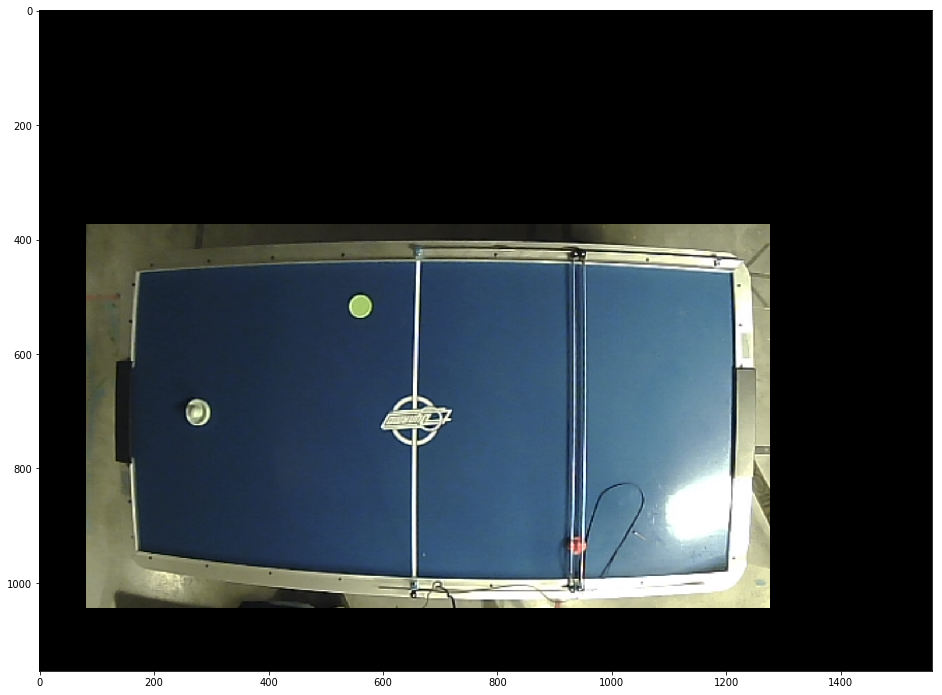

In [96]:
## isolate the table
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
box = find_table(rgb)
table = rgb.copy()
table[0:min(box[:,1]),:] = 0
table[max(box[:,1]):,:] = 0
table[:,0:min(box[:,0])] = 0
table[:,max(box[:,0]):] = 0
show_img(table)

In [20]:
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

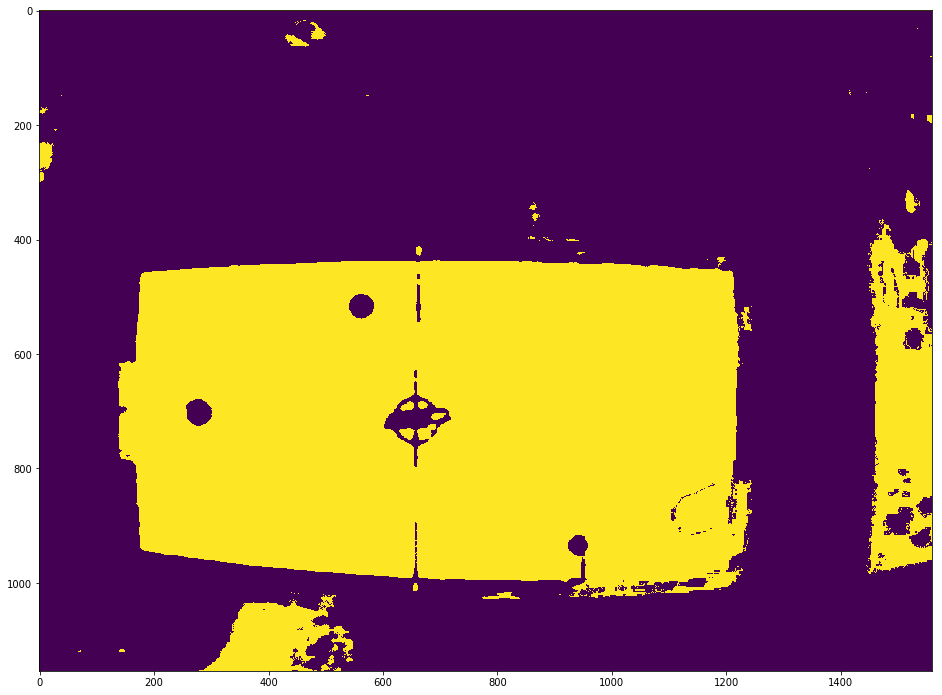

In [22]:
## isolate HUE

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
hsv[:,:,1:] = 0
t, hue = cv2.threshold(hsv, 50, 255, cv2.THRESH_BINARY)
hue = ~hue[:,:,0]
show_img(hue)

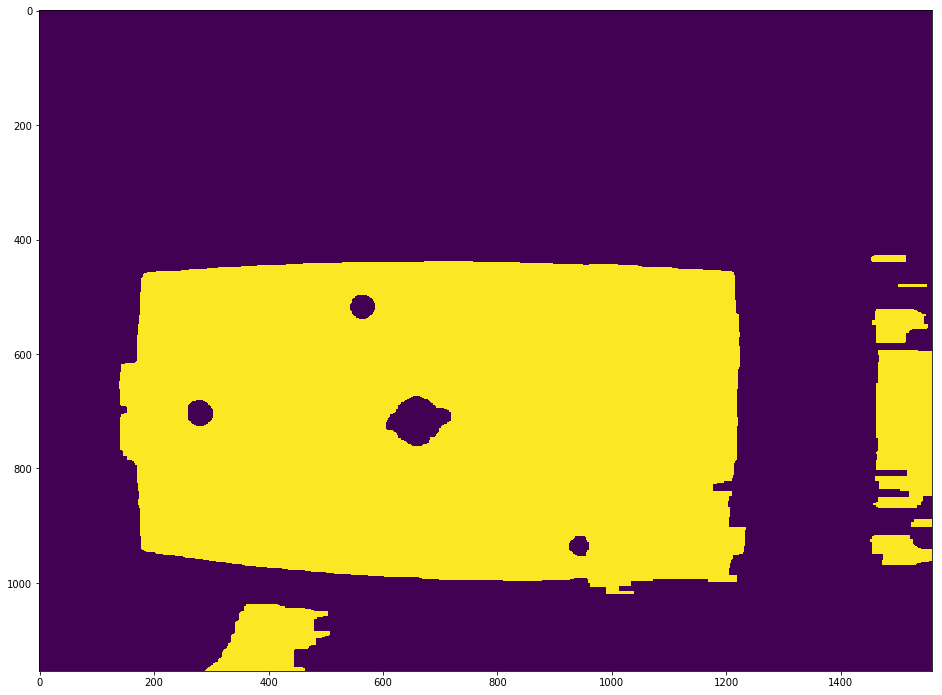

In [150]:
## denoise

kernel = np.ones((5, 50))
opened = cv2.morphologyEx(hue, cv2.MORPH_OPEN, kernel)
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, np.ones((10,10)))
show_img(closed)

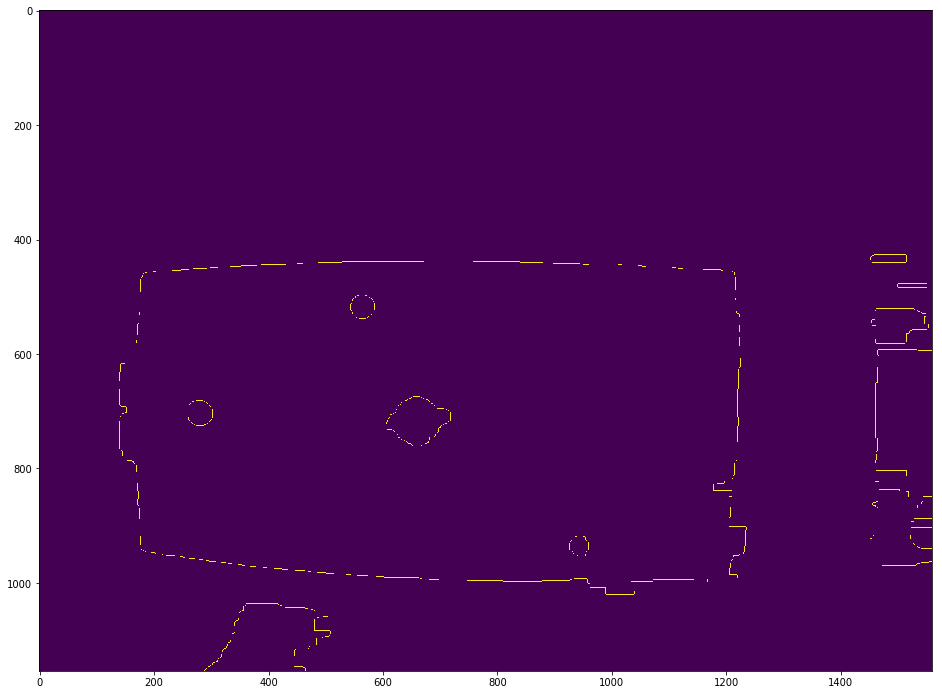

In [133]:
## edges are less work

laplacian = cv2.Laplacian(closed,cv2.CV_8UC1)
#edges = cv2.Canny(closed, 1, 1)
show_img(laplacian)

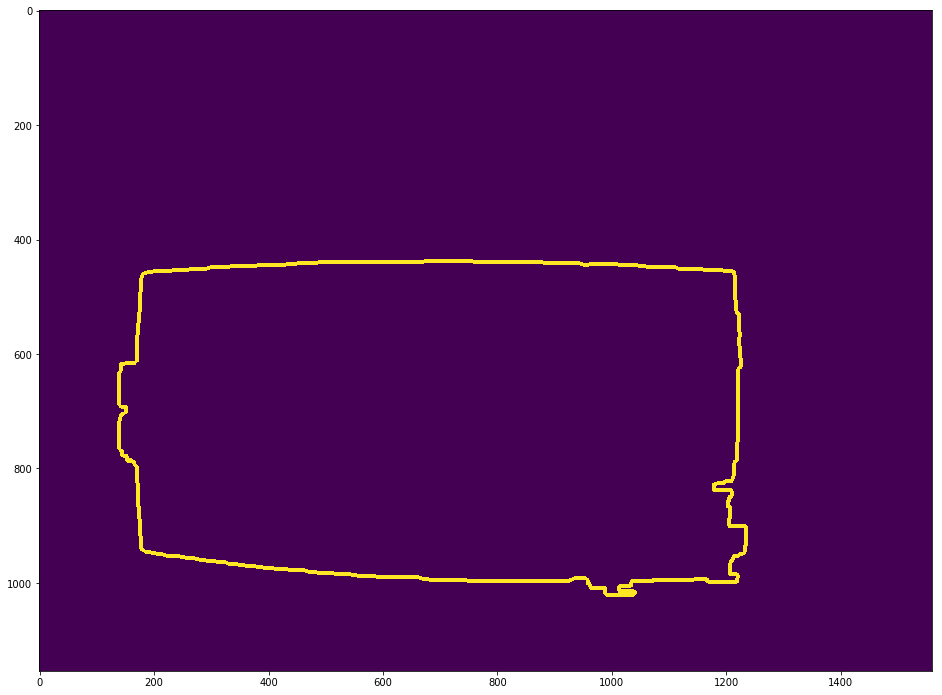

In [132]:
## find largest external blob

im2, outer_contours, hierarchy = cv2.findContours(laplacian, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
max_contour = max(outer_contours, key = cv2.contourArea)
test = cv2.drawContours(np.zeros_like(laplacian), [max_contour], -1, (255,255,255), 5)
show_img(test)

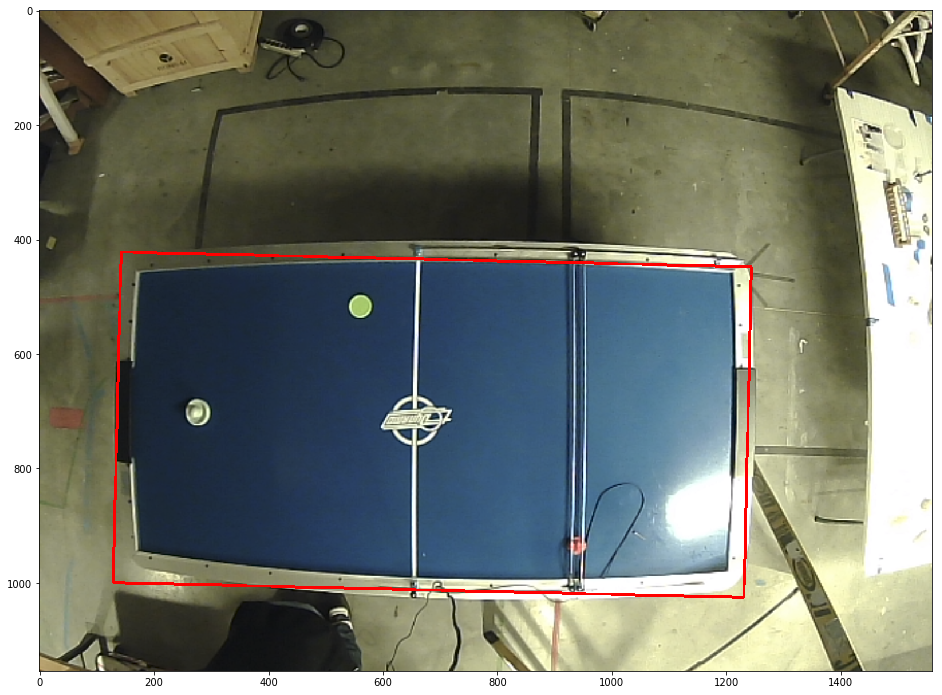

In [124]:
## translate playing area to a clean rect

rect = cv2.minAreaRect(max_contour)
box = cv2.boxPoints(rect)
box = np.int0(box)
disp = rgb.copy()
cv2.drawContours(disp,[box],0,(255,0,0),3)
show_img(disp)

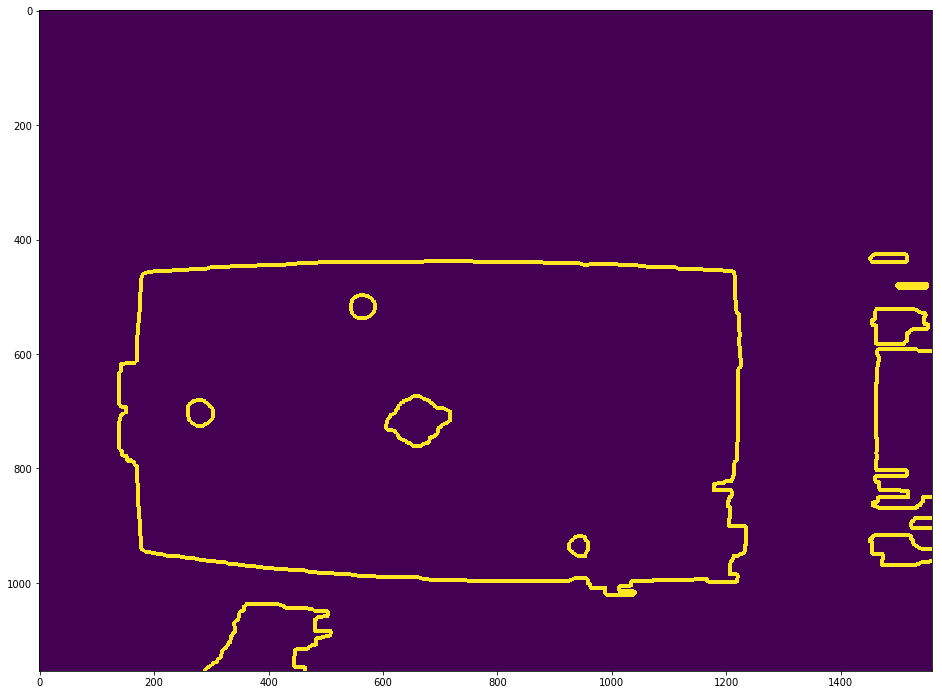

In [136]:
## draw all of the shapes

im2, all_contours, hierarchy = cv2.findContours(laplacian, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
                                                   
test = cv2.drawContours(np.zeros_like(laplacian), all_contours, -1, (255,255,255), 5)
show_img(test)

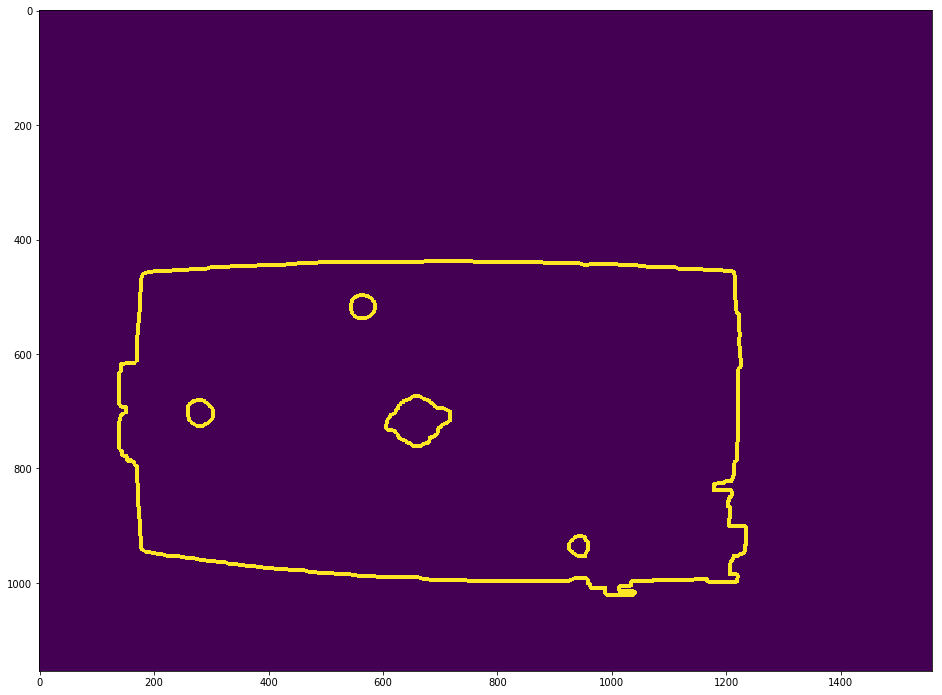

In [149]:
## isolate the shapes inside the table area

def point_in_box(point, box):
    retval = point[0] > min(box[:,0]) and point[0] < max(box[:,0]) and point[1] > min(box[:,1]) and point[1] < max(box[:,1])
    return retval

contours_in_box = [c for c in all_contours if np.all(point_in_box(c[0,0,:], box))]

test = cv2.drawContours(np.zeros_like(laplacian), contours_in_box, -1, (255,255,255), 5)
show_img(test)

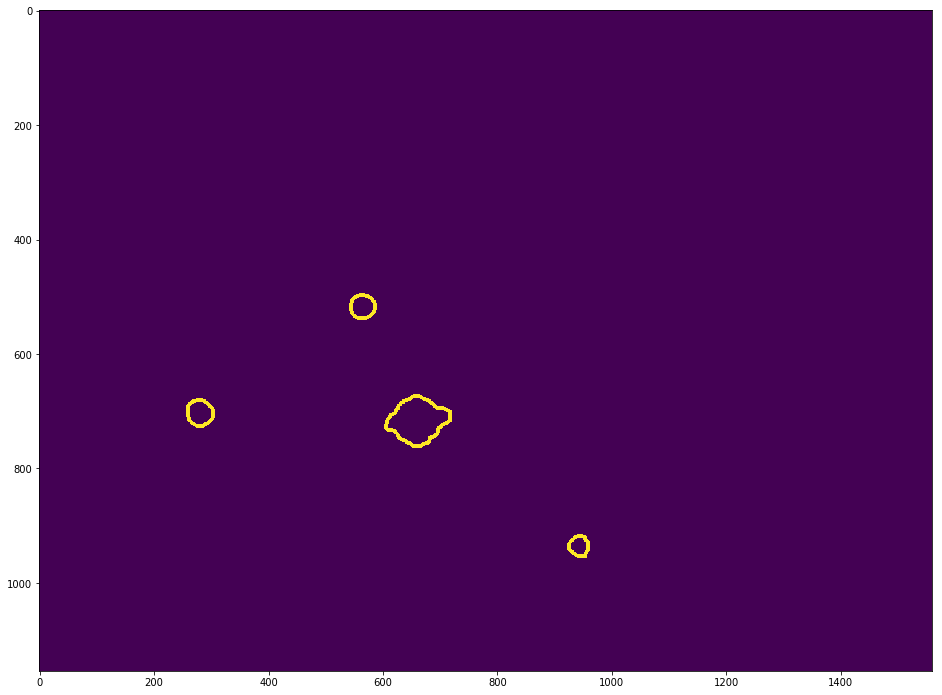

In [162]:
## filter out large shapes

def get_area(c):
    m = cv2.moments(c)
    return m['m00']

max_area = get_area(max_contour)
#print('Max Area = %.2f' %(max_area))

small_contours = [c for c in contours_in_box if (get_area(c) * 100 / max_area) < 50]
test = cv2.drawContours(np.zeros_like(laplacian), small_contours, -1, (255,255,255), 5)
show_img(test)

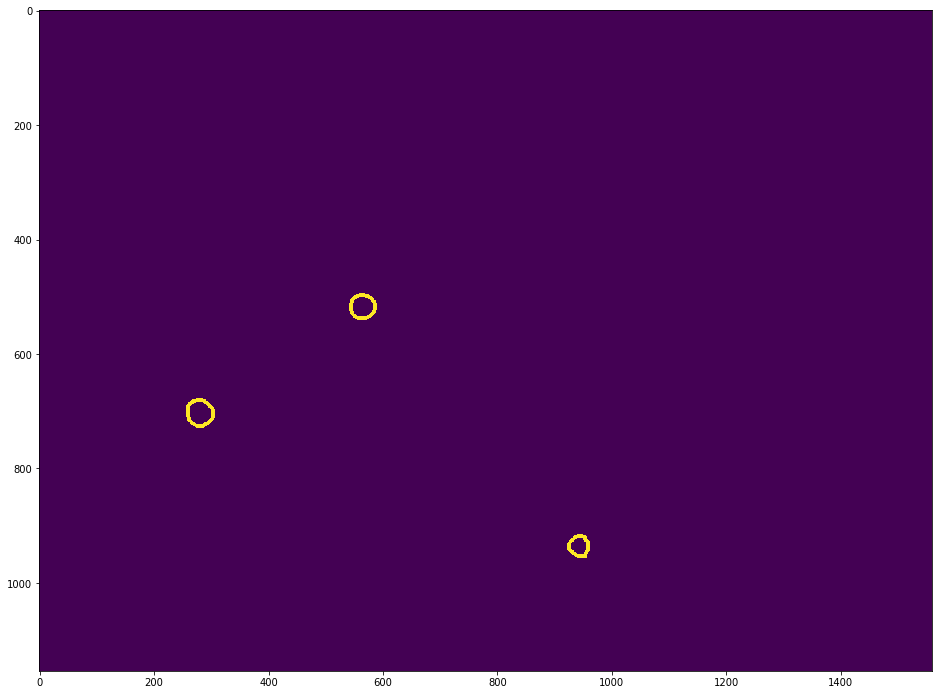

In [168]:
## filter out non-circular shapes

circular_contours = [c for c in small_contours if len(cv2.approxPolyDP(c,0.01*cv2.arcLength(c,True),True)) < 15]
test = cv2.drawContours(np.zeros_like(laplacian), circular_contours, -1, (255,255,255), 5)
show_img(test)

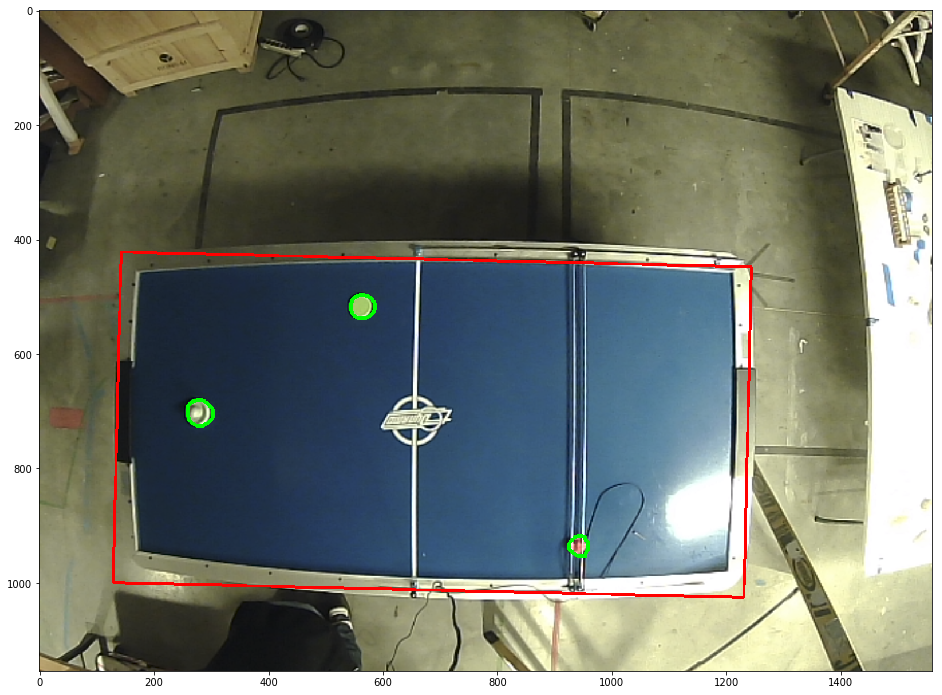

In [171]:
## put it all together

disp = rgb.copy()
cv2.drawContours(disp, [box], 0, (255, 0, 0), 3)
cv2.drawContours(disp, circular_contours, -1, (0,255,0), 5)
show_img(disp)